### Deep Learning

In [76]:
import os
import tensorflow
from tensorflow import device
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn import preprocessing

### VGG16

In [77]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 210, 210, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 210, 210, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 210, 210, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 105, 105, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 105, 105, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 105, 105, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 52, 52, 128)       0     

In [78]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 512))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 6* 6* 512))
validation_features = np.reshape(validation_features, (60, 6* 6* 512))
test_features = np.reshape(test_features, (84, 6* 6* 512))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [79]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 1s 16ms/step - loss: 1.1333 - acc: 0.3307 - val_loss: 1.0952 - val_acc: 0.3000
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1204 - acc: 0.3012 - val_loss: 1.0968 - val_acc: 0.3667
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1131 - acc: 0.3588 - val_loss: 1.0970 - val_acc: 0.3667
Epoch 4/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1035 - acc: 0.3874 - val_loss: 1.0981 - val_acc: 0.3667
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1191 - acc: 0.3474 - val_loss: 1.1001 - val_acc: 0.3000
Epoch 6/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1097 - acc: 0.3153 - val_loss: 1.0965 - val_acc: 0.3333
Epoch 7/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0986 - acc: 0.3213 - val_loss: 1.0960 - val_acc: 0.3667
Epoch 8/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0955 - acc: 0.3

26/26 [==============================] - 0s 9ms/step - loss: 1.1133 - acc: 0.2966 - val_loss: 1.0977 - val_acc: 0.3667
Epoch 6/30
26/26 [==============================] - 0s 13ms/step - loss: 1.0975 - acc: 0.3790 - val_loss: 1.0968 - val_acc: 0.4000
Epoch 7/30
26/26 [==============================] - 0s 11ms/step - loss: 1.1013 - acc: 0.3437 - val_loss: 1.0947 - val_acc: 0.4000
Epoch 8/30
26/26 [==============================] - 0s 11ms/step - loss: 1.1004 - acc: 0.3436 - val_loss: 1.0949 - val_acc: 0.3167
Epoch 9/30
26/26 [==============================] - 0s 12ms/step - loss: 1.1024 - acc: 0.3306 - val_loss: 1.0957 - val_acc: 0.4333
Epoch 10/30
26/26 [==============================] - 0s 13ms/step - loss: 1.0996 - acc: 0.3201 - val_loss: 1.0959 - val_acc: 0.3833
Epoch 11/30
26/26 [==============================] - 0s 9ms/step - loss: 1.0952 - acc: 0.3517 - val_loss: 1.0983 - val_acc: 0.3333
Epoch 12/30
26/26 [==============================] - 0s 8ms/step - loss: 1.0992 - acc: 0.3337 

In [80]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10784294605255126 - Accuracy: 0.3919999897480011%
>       BAC: 0.5 - F1: 0.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.108652663230896 - Accuracy: 0.5120000243186951%
>       BAC: 0.6237373737373737 - F1: 0.6285714285714286%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.10922437906265259 - Accuracy: 0.35199999809265137%
>       BAC: 0.5303030303030303 - F1: 0.11428571428571428%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.10954463481903076 - Accuracy: 0.3840000033378601%
>       BAC: 0.3333333333333333 - F1: 0.0%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10869581699371338 - Accuracy: 0.4193548262119293%
>       BAC: 0.

In [81]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprVgg16 = []
tprVgg16 = []
roc_aucVgg16 = []
for i in range(3):
    if roc_aucAfter[i] != max(roc_aucAfter) and roc_aucAfter[i] != min(roc_aucAfter):
        fprVgg16 = fpr[i]
        tprVgg16 = tpr[i]
        roc_aucVgg16 = roc_auc[i]
        
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### Vgg19

In [82]:
from tensorflow.keras.applications import VGG19

conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 210, 210, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 210, 210, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 210, 210, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 105, 105, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 105, 105, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 105, 105, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 52, 52, 128)       0     

In [83]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 512))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 6* 6* 512))
validation_features = np.reshape(validation_features, (60, 6* 6* 512))
test_features = np.reshape(test_features, (84, 6* 6* 512))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [84]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=6* 6* 512))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 1s 19ms/step - loss: 1.1272 - acc: 0.2887 - val_loss: 1.1024 - val_acc: 0.4167
Epoch 2/30
26/26 [==============================] - 0s 10ms/step - loss: 1.1119 - acc: 0.3361 - val_loss: 1.1000 - val_acc: 0.3333
Epoch 3/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1300 - acc: 0.2798 - val_loss: 1.0951 - val_acc: 0.3500
Epoch 4/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1017 - acc: 0.3448 - val_loss: 1.0992 - val_acc: 0.3500
Epoch 5/30
26/26 [==============================] - 0s 9ms/step - loss: 1.0962 - acc: 0.3756 - val_loss: 1.0968 - val_acc: 0.3667
Epoch 6/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1066 - acc: 0.3277 - val_loss: 1.0994 - val_acc: 0.3000
Epoch 7/30
26/26 [==============================] - 0s 9ms/step - loss: 1.1001 - acc: 0.3620 - val_loss: 1.0987 - val_acc: 0.3500
Epoch 8/30
26/26 [==============================] - 0s 8ms/step - loss: 1.1017 - acc: 0.

26/26 [==============================] - 0s 10ms/step - loss: 1.1117 - acc: 0.2999 - val_loss: 1.0977 - val_acc: 0.4167
Epoch 6/30
26/26 [==============================] - 0s 10ms/step - loss: 1.0986 - acc: 0.3022 - val_loss: 1.0991 - val_acc: 0.3333
Epoch 7/30
26/26 [==============================] - 0s 10ms/step - loss: 1.1014 - acc: 0.3302 - val_loss: 1.0986 - val_acc: 0.3500
Epoch 8/30
26/26 [==============================] - 0s 10ms/step - loss: 1.0988 - acc: 0.3460 - val_loss: 1.0997 - val_acc: 0.3333
Epoch 9/30
26/26 [==============================] - 0s 11ms/step - loss: 1.1045 - acc: 0.3476 - val_loss: 1.0975 - val_acc: 0.3500
Epoch 10/30
26/26 [==============================] - 0s 10ms/step - loss: 1.1004 - acc: 0.3697 - val_loss: 1.0982 - val_acc: 0.3667
Epoch 11/30
26/26 [==============================] - 0s 10ms/step - loss: 1.1152 - acc: 0.2943 - val_loss: 1.0984 - val_acc: 0.3167
Epoch 12/30
26/26 [==============================] - 0s 11ms/step - loss: 1.1102 - acc: 0.32

In [85]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10918874740600586 - Accuracy: 0.4000000059604645%
>       BAC: 0.5116279069767442 - F1: 0.045454545454545456%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.10940307378768921 - Accuracy: 0.36800000071525574%
>       BAC: 0.5 - F1: 0.5357142857142857%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.10960487127304078 - Accuracy: 0.3440000116825104%
>       BAC: 0.48460960960960964 - F1: 0.17391304347826086%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.10970747470855713 - Accuracy: 0.4000000059604645%
>       BAC: 0.5756756756756757 - F1: 0.4482758620689655%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.10951774120330811 - Accuracy: 

In [86]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprVgg19 = []
tprVgg19 = []
roc_aucVgg19 = []
for i in range(3):
    if roc_aucAfter[i] != max(roc_aucAfter) and roc_aucAfter[i] != min(roc_aucAfter):
        fprVgg19 = fpr[i]
        tprVgg19 = tpr[i]
        roc_aucVgg19 = roc_auc[i]
        
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### Xception

In [87]:
from tensorflow.keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 210, 210, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 104, 104, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 104, 104, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 104, 104, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [88]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 7* 7* 2048))
validation_features = np.reshape(validation_features, (60, 7* 7* 2048))
test_features = np.reshape(test_features, (84, 7* 7* 2048))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [89]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 2s 44ms/step - loss: 1.1241 - acc: 0.3550 - val_loss: 1.0789 - val_acc: 0.3333
Epoch 2/30
26/26 [==============================] - 1s 33ms/step - loss: 1.1049 - acc: 0.3759 - val_loss: 1.0860 - val_acc: 0.4000
Epoch 3/30
26/26 [==============================] - 1s 34ms/step - loss: 1.0807 - acc: 0.3752 - val_loss: 1.0580 - val_acc: 0.4500
Epoch 4/30
26/26 [==============================] - 1s 38ms/step - loss: 1.0711 - acc: 0.4070 - val_loss: 1.0497 - val_acc: 0.4500
Epoch 5/30
26/26 [==============================] - 1s 38ms/step - loss: 1.0440 - acc: 0.4474 - val_loss: 1.0310 - val_acc: 0.5000
Epoch 6/30
26/26 [==============================] - 1s 37ms/step - loss: 1.0630 - acc: 0.4203 - val_loss: 1.0333 - val_acc: 0.4500
Epoch 7/30
26/26 [==============================] - 1s 40ms/step - loss: 1.0454 - acc: 0.4227 - val_loss: 1.0221 - val_acc: 0.5500
Epoch 8/30
26/26 [==============================] - 1s 38ms/step - loss: 1.0269 - a

26/26 [==============================] - 1s 33ms/step - loss: 1.0374 - acc: 0.4943 - val_loss: 1.0499 - val_acc: 0.5167
Epoch 6/30
26/26 [==============================] - 1s 33ms/step - loss: 1.0544 - acc: 0.4395 - val_loss: 1.0456 - val_acc: 0.5167
Epoch 7/30
26/26 [==============================] - 1s 34ms/step - loss: 1.0222 - acc: 0.4795 - val_loss: 1.0414 - val_acc: 0.5167
Epoch 8/30
26/26 [==============================] - 1s 33ms/step - loss: 1.0475 - acc: 0.4304 - val_loss: 1.0365 - val_acc: 0.4833
Epoch 9/30
26/26 [==============================] - 1s 32ms/step - loss: 1.0319 - acc: 0.4666 - val_loss: 1.0287 - val_acc: 0.4667
Epoch 10/30
26/26 [==============================] - 1s 32ms/step - loss: 0.9897 - acc: 0.4811 - val_loss: 1.0433 - val_acc: 0.4500
Epoch 11/30
26/26 [==============================] - 1s 32ms/step - loss: 0.9964 - acc: 0.4734 - val_loss: 1.0496 - val_acc: 0.4500
Epoch 12/30
26/26 [==============================] - 1s 32ms/step - loss: 0.9981 - acc: 0.52

In [90]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.07245122194290161 - Accuracy: 0.6800000071525574%
>       BAC: 0.6875 - F1: 0.6197183098591549%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.06993256211280822 - Accuracy: 0.6880000233650208%
>       BAC: 0.6416666666666666 - F1: 0.47368421052631576%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.07642709612846374 - Accuracy: 0.6959999799728394%
>       BAC: 0.7504480286738351 - F1: 0.746268656716418%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.06814013719558716 - Accuracy: 0.7279999852180481%
>       BAC: 0.7178861788617886 - F1: 0.64%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.07274333834648132 - Accuracy: 0.69354838132858

In [91]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprXception = []
tprXception = []
roc_aucXception = []
for i in range(3):
    if roc_aucAfter[i] != max(roc_aucAfter) and roc_aucAfter[i] != min(roc_aucAfter):
        fprXception = fpr[i]
        tprXception = tpr[i]
        roc_aucXception = roc_auc[i]
        
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### DenseNet121

In [181]:
from tensorflow.keras.applications import DenseNet121

conv_base = DenseNet121(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 210, 210, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 216, 216, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 105, 105, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 105, 105, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [182]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 6, 6, 1024))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 6* 6* 1024))
validation_features = np.reshape(validation_features, (60, 6* 6* 1024))
test_features = np.reshape(test_features, (84, 6* 6* 1024))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [183]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=5, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(128, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=6* 6* 1024))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=30, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
    f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1


Epoch 1/30
26/26 [==============================] - 1s 25ms/step - loss: 1.2430 - acc: 0.3070 - val_loss: 1.0959 - val_acc: 0.3500
Epoch 2/30
26/26 [==============================] - 0s 13ms/step - loss: 1.1467 - acc: 0.3230 - val_loss: 1.0954 - val_acc: 0.3833
Epoch 3/30
26/26 [==============================] - 0s 13ms/step - loss: 1.1298 - acc: 0.3755 - val_loss: 1.1009 - val_acc: 0.3333
Epoch 4/30
26/26 [==============================] - 0s 14ms/step - loss: 1.1153 - acc: 0.3432 - val_loss: 1.0919 - val_acc: 0.3167
Epoch 5/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0989 - acc: 0.3110 - val_loss: 1.0881 - val_acc: 0.4000
Epoch 6/30
26/26 [==============================] - 0s 15ms/step - loss: 1.0902 - acc: 0.4036 - val_loss: 1.0787 - val_acc: 0.3833
Epoch 7/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0672 - acc: 0.3957 - val_loss: 1.0582 - val_acc: 0.4833
Epoch 8/30
26/26 [==============================] - 0s 15ms/step - loss: 1.0474 - a

26/26 [==============================] - 0s 14ms/step - loss: 1.1148 - acc: 0.3988 - val_loss: 1.0928 - val_acc: 0.4000
Epoch 4/30
26/26 [==============================] - 0s 15ms/step - loss: 1.1280 - acc: 0.3394 - val_loss: 1.0956 - val_acc: 0.3667
Epoch 5/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0890 - acc: 0.3808 - val_loss: 1.1024 - val_acc: 0.3333
Epoch 6/30
26/26 [==============================] - 0s 14ms/step - loss: 1.1299 - acc: 0.3133 - val_loss: 1.0962 - val_acc: 0.3333
Epoch 7/30
26/26 [==============================] - 0s 16ms/step - loss: 1.0899 - acc: 0.3909 - val_loss: 1.0838 - val_acc: 0.3333
Epoch 8/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0808 - acc: 0.3973 - val_loss: 1.0789 - val_acc: 0.4333
Epoch 9/30
26/26 [==============================] - 0s 16ms/step - loss: 1.0741 - acc: 0.3537 - val_loss: 1.0715 - val_acc: 0.4667
Epoch 10/30
26/26 [==============================] - 0s 15ms/step - loss: 1.0758 - acc: 0.4023

26/26 [==============================] - 0s 14ms/step - loss: 1.0741 - acc: 0.4056 - val_loss: 1.0745 - val_acc: 0.4333
Epoch 6/30
26/26 [==============================] - 0s 18ms/step - loss: 1.0716 - acc: 0.4395 - val_loss: 1.0725 - val_acc: 0.4333
Epoch 7/30
26/26 [==============================] - 0s 15ms/step - loss: 1.0700 - acc: 0.4644 - val_loss: 1.0548 - val_acc: 0.5167
Epoch 8/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0390 - acc: 0.4395 - val_loss: 1.0498 - val_acc: 0.4667
Epoch 9/30
26/26 [==============================] - 0s 14ms/step - loss: 1.0416 - acc: 0.4779 - val_loss: 1.0303 - val_acc: 0.4500
Epoch 10/30
26/26 [==============================] - 0s 17ms/step - loss: 1.0402 - acc: 0.4595 - val_loss: 1.0290 - val_acc: 0.4500
Epoch 11/30
26/26 [==============================] - 0s 13ms/step - loss: 0.9986 - acc: 0.4559 - val_loss: 1.0247 - val_acc: 0.4667
Epoch 12/30
26/26 [==============================] - 0s 15ms/step - loss: 0.9835 - acc: 0.50

In [185]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.08020468354225159 - Accuracy: 0.656000018119812%
>       BAC: 0.6230769230769231 - F1: 0.47058823529411764%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.08457634449005128 - Accuracy: 0.656000018119812%
>       BAC: 0.6871794871794872 - F1: 0.5555555555555556%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.0892037570476532 - Accuracy: 0.6399999856948853%
>       BAC: 0.7336265884652982 - F1: 0.7213114754098361%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.08347463607788086 - Accuracy: 0.6480000019073486%
>       BAC: 0.6366935483870968 - F1: 0.576271186440678%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.07663876414299012 - Acc

In [188]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc

mylist = []
for j in test_labels: mylist.append([int(i) for i in j])
mylist = np.array(mylist)

# calculate the fpr and tpr for all thresholds of the classification
probs_ex = model_ex.predict(test_features)
preds_ex = probs_ex[:, 1]
n_classes = 3
    
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_aucAfter = []
for i in range(3): roc_aucAfter.append(roc_auc[i])
fprDenseNet121 = []
tprDenseNet121 = []
roc_aucDenseNet121 = []
fprResNet50 = []
tprResNet50 = []
roc_aucResNet50 = []
for i in range(3):
    if roc_aucAfter[i] != max(roc_aucAfter) and roc_aucAfter[i] != min(roc_aucAfter):
        fprDenseNet121 = fpr[i]
        tprDenseNet121 = tpr[i]
        roc_aucDenseNet121 = roc_auc[i]
    if roc_aucAfter[i] == max(roc_aucAfter):
        fprResNet50 = fpr[i]
        tprResNet50 = tpr[i]
        roc_aucResNet50 = roc_auc[i]
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

### ResNet50 

In [173]:
from tensorflow.keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(210,210, 3))

base_dir = 'C:\\Users\\feras\\Bovine data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)

batch_size = 21
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 210, 210, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 216, 216, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 105, 105, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 105, 105, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [175]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count, 3))
    
    if sample_count == 540:
        train_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1/255,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2)
    else:
        train_datagen =  ImageDataGenerator(rescale=1./255)
    
    generator = train_datagen.flow_from_directory(directory,
        target_size=(210,210),
        batch_size = batch_size, 
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 540)
validation_features, validation_labels = extract_features(validation_dir, 60)
test_features, test_labels = extract_features(test_dir, 84)
##----------------------------------------------------------
train_features = np.reshape(train_features, (540, 7* 7* 2048))
validation_features = np.reshape(validation_features, (60, 7* 7* 2048))
test_features = np.reshape(test_features, (84, 7* 7* 2048))
inputs = np.concatenate((train_features, test_features), axis=0)
targets = np.concatenate((train_labels, test_labels), axis=0)

Found 540 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [176]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
bac_per_fold = []
f1_per_fold = []
fold_no = 1

for train, test in KFold(n_splits=2, shuffle=True).split(inputs, targets):
    model_ex = models.Sequential()
    model_ex.add(layers.Flatten())
    model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
#     model_ex.add(layers.Dropout(0.5))
#     model_ex.add(layers.Dense(128, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(256, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dense(64, activation='relu', input_dim=7* 7* 2048))
    model_ex.add(layers.Dropout(0.5))
    model_ex.add(layers.Dense(3, activation='softmax'))

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model_ex.compile(optimizer=optimizers.SGD(lr= 0.0030),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    with device('/GPU:0'):
        history = model_ex.fit(train_features, train_labels, epochs=15, batch_size=batch_size, validation_data=(validation_features, validation_labels))

    # Generate generalization metrics
    predctions = np.argmax(model_ex.predict(inputs[test], batch_size=batch_size,verbose=0), axis=-1)
    scores = model_ex.evaluate(inputs[test], targets[test], verbose=0)
    acc_per_fold.append((scores[1] * 100))
    loss_per_fold.append(scores[0])
    
    rounded_labels=np.argmax(targets[test], axis=1)
    
    tn, fp, fn, tp = confusion_matrix(rounded_labels, predctions, labels=[0,1]).ravel()
    if tp+fn == 0 or tn+fp == 0:
        bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp + 0.1)))
        f1 = (2*tp)/(2*tp+fp+fn + 0.1)
    else:
        bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp)))
        f1 = (2*tp)/(2*tp+fp+fn)
    bac_per_fold.append(bac) # balanced accuracy
    f1_per_fold.append(f1) # F1
    
    # Increase fold number
    fold_no = fold_no + 1

Epoch 1/15
26/26 [==============================] - 2s 58ms/step - loss: 1.5173 - acc: 0.3464 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/15
26/26 [==============================] - 1s 29ms/step - loss: 1.0987 - acc: 0.3428 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/15
26/26 [==============================] - 1s 29ms/step - loss: 1.0987 - acc: 0.2997 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/15
26/26 [==============================] - 1s 28ms/step - loss: 1.0986 - acc: 0.3091 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/15
26/26 [==============================] - 1s 28ms/step - loss: 1.0988 - acc: 0.2838 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/15
26/26 [==============================] - 1s 28ms/step - loss: 1.0986 - acc: 0.3005 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/15
26/26 [==============================] - 1s 29ms/step - loss: 1.0987 - acc: 0.3192 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/15
26/26 [==============================] - 1s 28ms/step - loss: 1.0986 - a

<ipython-input-176-ce2a1faedfeb>:46: RuntimeWarning: invalid value encountered in longlong_scalars
  bac = 0.5*((tp/(tp+fn))+(tn/(tn+fp + 0.1)))


Epoch 1/15
26/26 [==============================] - 2s 38ms/step - loss: 1.6596 - acc: 0.3004 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/15
26/26 [==============================] - 1s 32ms/step - loss: 1.0986 - acc: 0.3497 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/15
26/26 [==============================] - 1s 33ms/step - loss: 1.0987 - acc: 0.3056 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/15
26/26 [==============================] - 1s 33ms/step - loss: 1.0987 - acc: 0.3490 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/15
26/26 [==============================] - 1s 35ms/step - loss: 1.0986 - acc: 0.3279 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 6/15
26/26 [==============================] - 1s 34ms/step - loss: 1.0986 - acc: 0.3337 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 7/15
26/26 [==============================] - 1s 32ms/step - loss: 1.0987 - acc: 0.3146 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/15
26/26 [==============================] - 1s 31ms/step - loss: 1.0986 - a

In [178]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]/10} - Accuracy: {acc_per_fold[i]/100}%')
    print(f'>       BAC: {bac_per_fold[i]} - F1: {f1_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)/100} (+- {np.std(acc_per_fold)})')
print(f'> BAC: {np.mean(bac_per_fold)} (+- {np.std(bac_per_fold)})')
print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)/10}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.10985383987426758 - Accuracy: 0.375%
>       BAC: nan - F1: 0.0%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.10985620021820068 - Accuracy: 0.3621794879436493%
>       BAC: 0.5 - F1: 0.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 0.36858974397182465 (+- 0.6410256028175354)
> BAC: nan (+- nan)
> F1: 0.0 (+- 0.0)
> Loss: 0.10985502004623413
------------------------------------------------------------------------


In [179]:
# import sklearn.metrics as metrics
# from sklearn.metrics import roc_curve, auc

# mylist = []
# for j in test_labels: mylist.append([int(i) for i in j])
# mylist = np.array(mylist)

# # calculate the fpr and tpr for all thresholds of the classification
# probs_ex = model_ex.predict(test_features)
# preds_ex = probs_ex[:, 1]
# n_classes = 3
    
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(mylist[:, i], probs_ex[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
    
# roc_aucAfter = []
# for i in range(3): roc_aucAfter.append(roc_auc[i])
# fprResNet50 = []
# tprResNet50 = []
# roc_aucResNet50 = []
# for i in range(3):
#     if roc_aucAfter[i] != max(roc_aucAfter) and roc_aucAfter[i] != min(roc_aucAfter):
#         fprResNet50 = fpr[i]
#         tprResNet50 = tpr[i]
#         roc_aucResNet50 = roc_auc[i]
#         o = 1
# if roc_aucResNet50 == []:
#     fprResNet50 = fpr[0]
#     tprResNet50 = tpr[0]
#     roc_aucResNet50 = roc_auc[0]
        
# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(mylist.ravel(), probs_ex.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

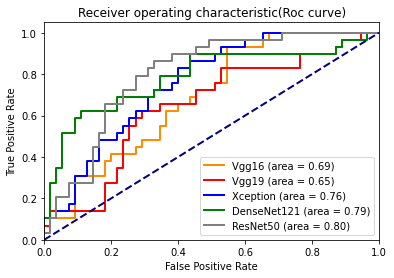

In [189]:
plt.figure()
lw = 2
plt.plot(fprVgg16, tprVgg16, color='darkorange',
         lw=lw, label='Vgg16 (area = %0.2f)' % roc_aucVgg16)
plt.plot(fprVgg19, tprVgg19, color='red',
         lw=lw, label='Vgg19 (area = %0.2f)' % roc_aucVgg19)
plt.plot(fprXception, tprXception, color='blue',
         lw=lw, label='Xception (area = %0.2f)' % roc_aucXception)
plt.plot(fprDenseNet121, tprDenseNet121, color='green',
         lw=lw, label='DenseNet121 (area = %0.2f)' % roc_aucDenseNet121)
plt.plot(fprResNet50, tprResNet50, color='gray',
         lw=lw, label='ResNet50 (area = %0.2f)' % roc_aucResNet50)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(Roc curve)')
plt.legend(loc="lower right")
plt.show()